## **EcoFlux: A Machine Learning Energy Consumption Estimator**  
          Making machine learning greener through transparency         
    
**Author**: Sabrina Ronnie George Karippatt - 8991911
        Jiho Jun                        - 
        Edwin Lopez                     - 
        Andrew Silveira                 - 

**Course:** *Foundations of Machine Learning Frameworks* 

**Date:** 23-11-2025

### **Dataset Creation & Methodology**

In this section we generate a synthetic dataset for **EcoFlux**, a machine learning energy consumption estimator. The dataset encodes a simple, transparent relationship between three input features:

   - `num_layers` – number of layers in the model  
   - `training_hours` – total training time in hours  
   - `flops_per_hour` – approximate compute intensity in GFLOPs/hour  

and a continuous target:
   - `energy_kwh` – approximate total energy usage in kWh

The goal is to create a small, reproducible dataset that captures the expected
trends between model complexity, training time, and energy consumption.

In [1]:
# --- EcoFlux synthetic dataset generation --- #
import numpy as np
import pandas as pd
from pathlib import Path

rng = np.random.default_rng(42)  # reproducible

n_rows = 60  # 40–100 is reasonable for this project

# Feature sampling
num_layers = rng.integers(2, 25, size=n_rows)          # 2–24 layers
training_hours = rng.uniform(0.5, 24.0, size=n_rows)   # hours
flops_per_hour = rng.uniform(10.0, 300.0, size=n_rows) # GFLOPs/hour

# Underlying "true" energy model with noise
base = 0.5
energy_kwh = (
    base
    + 0.05 * num_layers
    + 0.02 * training_hours * (flops_per_hour / 50.0)
    + rng.normal(0, 0.8, size=n_rows)  # small Gaussian noise
)

# Clip to non-negative energies
energy_kwh = np.clip(energy_kwh, a_min=0.2, a_max=None)

df = pd.DataFrame({
    "num_layers": num_layers,
    "training_hours": training_hours.round(2),
    "flops_per_hour": flops_per_hour.round(1),
    "energy_kwh": energy_kwh.round(2),
})

display(df.head())

# Save to ../data
data_dir = Path("..") / "data"
data_dir.mkdir(parents=True, exist_ok=True)
csv_path = data_dir / "energy_synthetic.csv"
df.to_csv(csv_path, index=False)

print(f"Saved synthetic dataset to: {csv_path.resolve()}")
print("Shape:", df.shape)

,num_layers,training_hours,flops_per_hour,energy_kwh
0,4,18.00,54.2,1.94
1,19,23.24,211.9,3.55
2,17,8.16,139.4,1.68
3,12,9.21,120.5,0.72
4,11,11.53,97.4,0.20


Saved synthetic dataset to: C:\Users\user\1557_VSC\MLF_MVP\data\energy_synthetic.csv
Shape: (60, 4)


**Dataset Generation Summary**

The synthetic EcoFlux dataset was successfully generated using the formula described in the methodology section. A total of **60 samples** were created, each representing a hypothetical model-training configuration with four variables:

- `num_layers` — model depth  
- `training_hours` — duration of training  
- `flops_per_hour` — compute intensity  
- `energy_kwh` — estimated energy consumption (target)

The preview above shows the first 5 rows of the dataset, and the full CSV has been saved to:
   - ../data/energy_synthetic.csv
   
This dataset is fully reproducible, noise-aware, and designed specifically for training and evaluating the EcoFlux regression models.

### **Basic Dataset Validation**

Before proceeding to exploratory analysis or model training, we perform simple sanity checks to ensure the synthetic dataset was generated correctly.  
This includes:

- confirming column data types  
- checking statistical ranges  
- verifying that no missing values exist  

These checks help ensure the EcoFlux modeling pipeline begins with a clean, reliable dataset.

In [2]:
# Basic sanity checks
print(df.info())
display(df.describe())

print("\nMissing values per column:")
print(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 60 entries, 0 to 59
Data columns (total 4 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   num_layers      60 non-null     int64  
 1   training_hours  60 non-null     float64
 2   flops_per_hour  60 non-null     float64
 3   energy_kwh      60 non-null     float64
dtypes: float64(3), int64(1)
memory usage: 2.0 KB
None


,num_layers,training_hours,flops_per_hour,energy_kwh
count,60.000000,60.000000,60.000000,60.000000
mean,13.616667,11.372667,146.451667,1.893000
std,6.322121,6.058481,80.001620,1.048919
min,3.000000,0.670000,16.300000,0.200000
25%,9.500000,5.957500,87.325000,1.092500
50%,14.000000,11.440000,144.750000,1.800000
75%,19.000000,16.315000,201.850000,2.532500
max,24.000000,23.240000,291.100000,4.990000



Missing values per column:
num_layers        0
training_hours    0
flops_per_hour    0
energy_kwh        0
dtype: int64


**Validation Summary**

The sanity-check results confirm that the EcoFlux dataset is valid:

- All 60 rows are present with no missing values  
- Data types are correct (`int` for layers, `float` for all others)  
- Summary statistics show realistic and diverse values across all features  

With the dataset confirmed to be clean and correctly structured, we can now move to **Exploratory Data Analysis (EDA)** to understand patterns and
relationships before building the regression models.

### **Exploratory Data Analysis (EDA)**

To better understand the structure of the EcoFlux synthetic dataset, this section visualizes the distributions of all variables, examines relationships between inputs and the target (`energy_kwh`), and inspects correlations. These plots help confirm that the dataset behaves as expected and provide intuition for how each feature contributes to energy consumption.

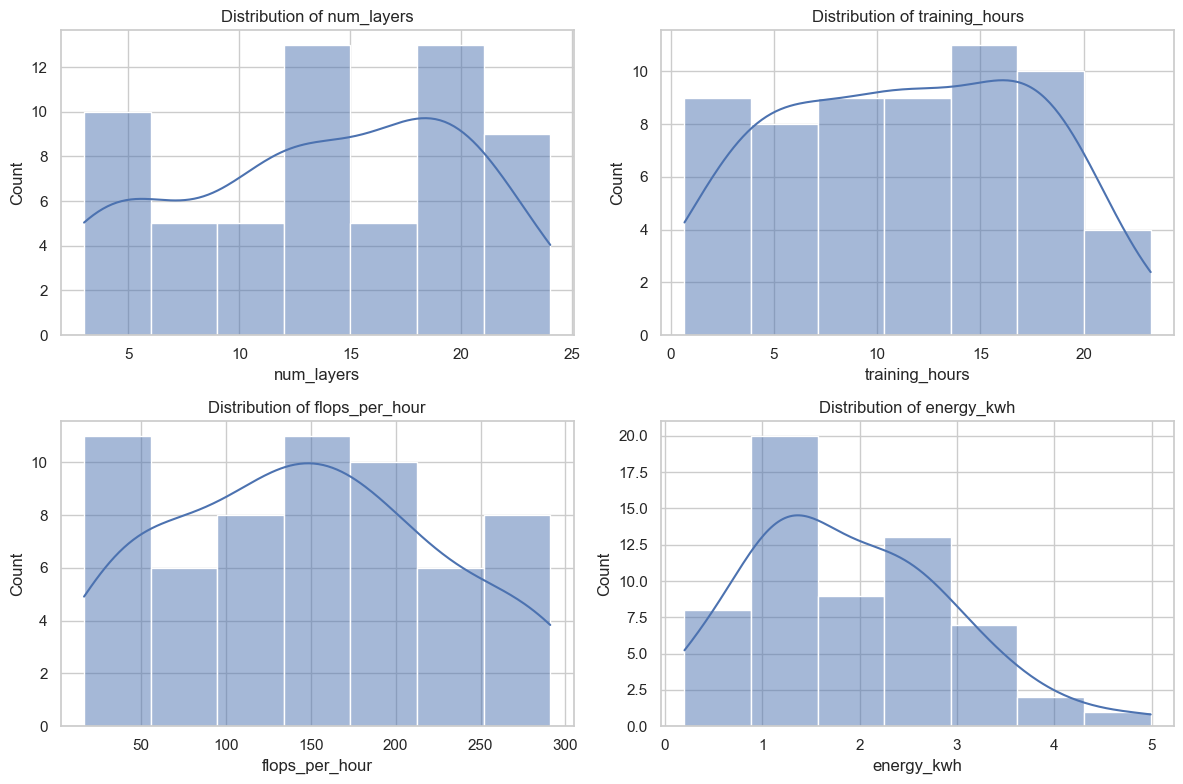

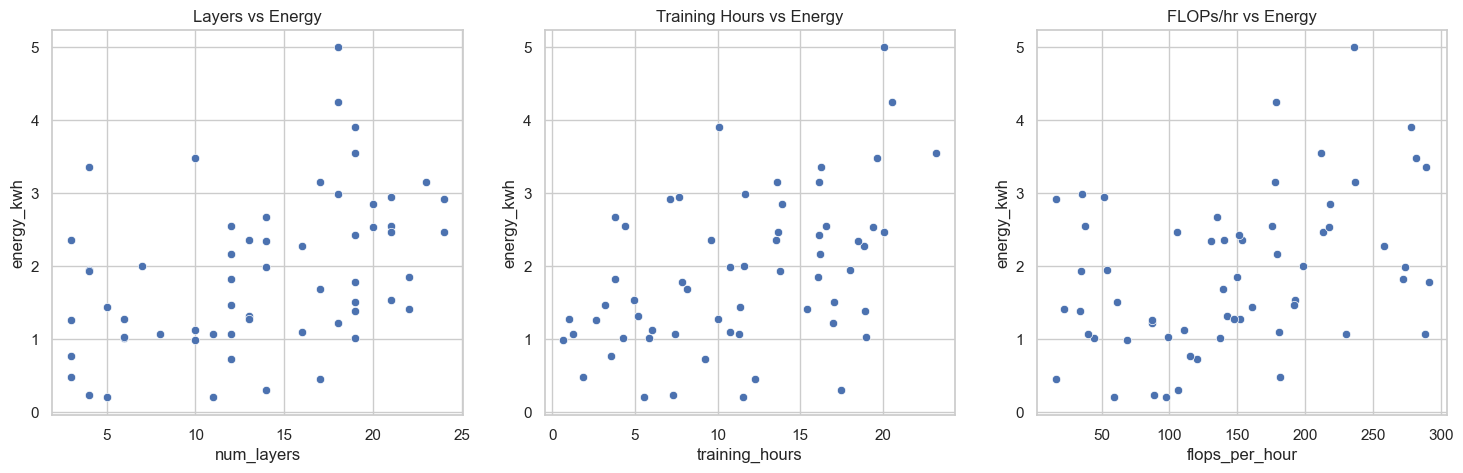

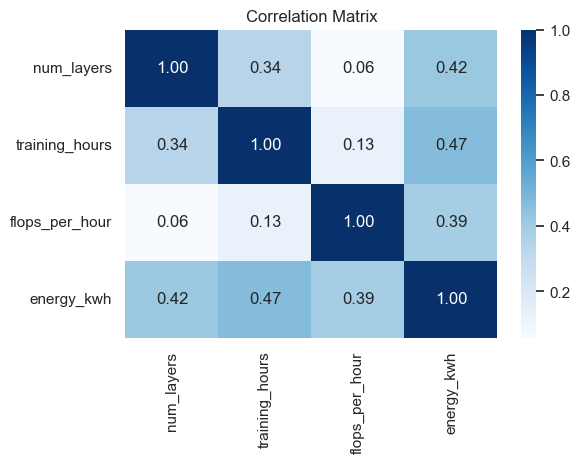

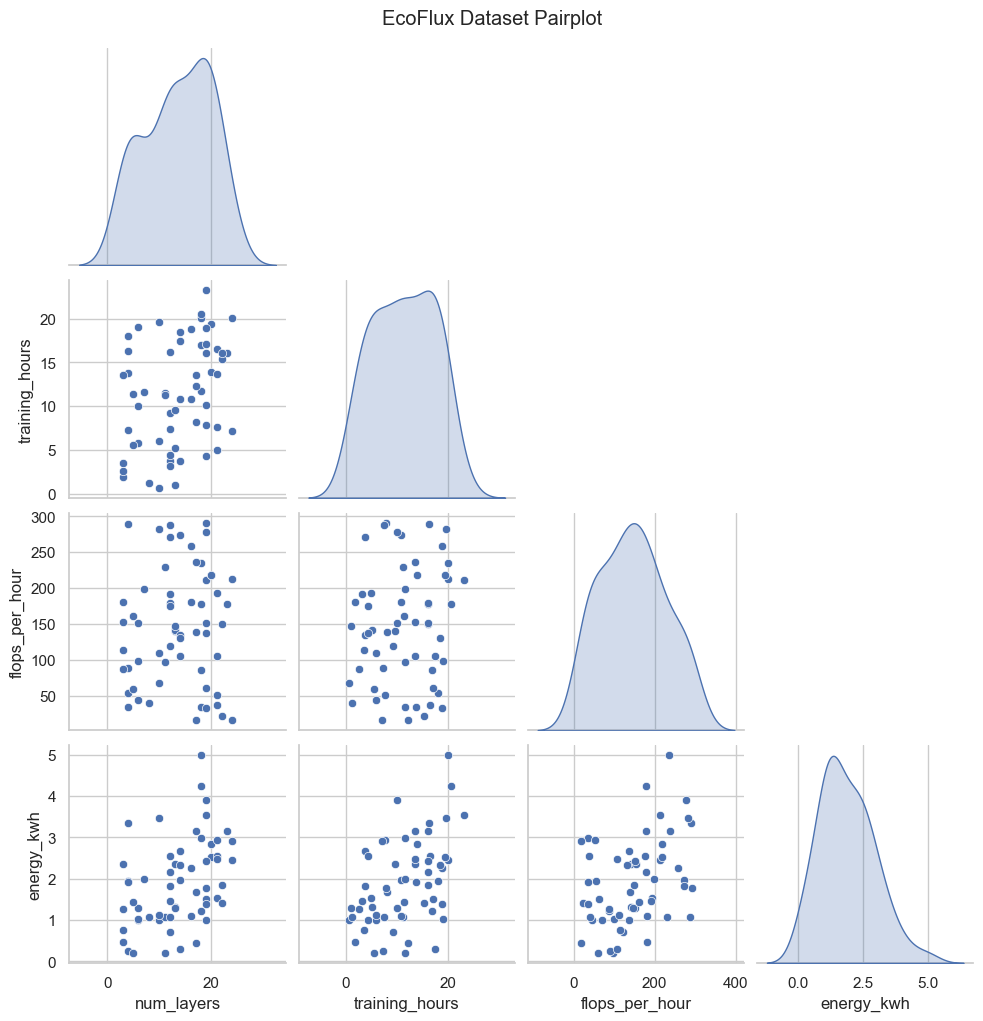

In [3]:
import matplotlib.pyplot as plt
import seaborn as sns

sns.set(style="whitegrid")

# -----------------------------
# 1. Distribution Plots (Histograms)
# -----------------------------
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

columns = ["num_layers", "training_hours", "flops_per_hour", "energy_kwh"]

for ax, col in zip(axes.flatten(), columns):
    sns.histplot(df[col], kde=True, ax=ax)
    ax.set_title(f"Distribution of {col}")

plt.tight_layout()
plt.show()


# -----------------------------
# 2. Scatter Plots vs Target
# -----------------------------
fig, axes = plt.subplots(1, 3, figsize=(18, 5))

sns.scatterplot(x="num_layers", y="energy_kwh", data=df, ax=axes[0])
sns.scatterplot(x="training_hours", y="energy_kwh", data=df, ax=axes[1])
sns.scatterplot(x="flops_per_hour", y="energy_kwh", data=df, ax=axes[2])

axes[0].set_title("Layers vs Energy")
axes[1].set_title("Training Hours vs Energy")
axes[2].set_title("FLOPs/hr vs Energy")

plt.show()


# -----------------------------
# 3. Correlation Heatmap
# -----------------------------
plt.figure(figsize=(6, 4))
corr = df.corr(numeric_only=True)

sns.heatmap(corr, annot=True, cmap="Blues", fmt=".2f")
plt.title("Correlation Matrix")
plt.show()


# -----------------------------
# 4. Pairplot (Corner=True)
# -----------------------------
sns.pairplot(df, diag_kind="kde", corner=True)
plt.suptitle("EcoFlux Dataset Pairplot", y=1.02)
plt.show()

**EDA Summary**

The visual analysis provides several important insights:

**• Feature distributions:**  
All four variables show smooth, realistic spreads with no missing values or unexpected spikes. This confirms the synthetic sampling behaved correctly.

**• Scatter plots:**  
Clear upward trends appear between all three input features and energy usage. This matches the synthetic formula: deeper models, longer training, and higher compute intensity all increase `energy_kwh`.

**• Correlation matrix:**  
Moderate positive correlations are visible between each feature and `energy_kwh`, with no signs of multicollinearity. This indicates that both linear and nonlinear regressors should perform well.

**• Pairplot:**  
Pairwise relationships are clean and continuous, with no outliers or strange clusters. This reinforces the dataset’s suitability for regression modeling.

With the dataset fully validated and explored, we can now proceed to **Model Development**, where EcoFlux will learn to predict energy consumption based on model architecture and compute characteristics.

### **Model Development**

In this section, EcoFlux learns to predict `energy_kwh` from the three input features:

- `num_layers`
- `training_hours`
- `flops_per_hour`

We build and compare two regression models:

1. A baseline **Linear Regression** model  
2. A small **MLPRegressor** (neural network) with standardized inputs  

Both models are trained on a train/test split of the synthetic dataset and evaluated using MAE, MSE, RMSE, and R². The trained models are then saved to disk for later use in the EcoFlux GUI.

**Part 1: Linear Regression**

In this step, we begin the model development phase by training a simple Linear Regression model on the EcoFlux dataset.
We will:
   - select the features (X) and target (y)
   - split the data into training/testing sets
   - fit a Linear Regression model
   - evaluate its performance using MAE, MSE, RMSE, and R²

This serves as our baseline model before introducing the neural network version.

In [ ]:
# Model Development

from pathlib import Path
import numpy as np
import pandas as pd

# scikit-learn tools for splitting, modeling, and evaluation
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

# Define features (X) and target (y)
# X contains the three independent variables
X = df[["num_layers", "training_hours", "flops_per_hour"]].values

# y contains the continuous energy target
y = df["energy_kwh"].values

# Train/Test split
# Reserve 25% of data for testing.
# random_state makes the split reproducible.
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.25, random_state=1911
)

print("Train shape:", X_train.shape, " Test shape:", X_test.shape)

# Baseline Model: Linear Regression
# Create the linear model
lin_reg = LinearRegression()

# Fit the model on the training data
lin_reg.fit(X_train, y_train)

# Predictions on train and test sets
y_train_pred_lin = lin_reg.predict(X_train)
y_test_pred_lin = lin_reg.predict(X_test)

# Helper function for metrics
def regression_metrics(y_true, y_pred):
    """Compute MAE, MSE, RMSE, and R² for regression performance."""
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, mse, rmse, r2

# Evaluate linear regression performance
lin_mae, lin_mse, lin_rmse, lin_r2 = regression_metrics(y_test, y_test_pred_lin)

print("\nLinear Regression (Test Set Results):")
print(f"  MAE  : {lin_mae:.3f}")
print(f"  MSE  : {lin_mse:.3f}")
print(f"  RMSE : {lin_rmse:.3f}")
print(f"  R²   : {lin_r2:.3f}")

Train shape: (45, 3)  Test shape: (15, 3)

Linear Regression (Test Set Results):
  MAE  : 0.696
  MSE  : 0.643
  RMSE : 0.802
  R²   : 0.441


**Summary**

The baseline Linear Regression model was successfully trained and evaluated.
 
Key observations from the test-set performance:
   - MAE: 0.696 → on average, predictions are off by ~0.70 kWh
   - RMSE: 0.802 → typical prediction error magnitude
   - R²: 0.441 → the model explains ~44% of the variance in energy consumption

This gives us a reasonable starting point, but also shows that energy usage is not fully linear, which justifies exploring a more flexible model next — the MLPRegressor.

**Part 2: MLPRegressor (Neural Network)**

To complement the linear baseline, we train a small neural network using `MLPRegressor`. Unlike linear regression, neural networks can capture
non-linear relationships, but they require standardized inputs to perform well.

In this step, we:

   - Standardize the training and test features  
   - Define a two-layer neural network  
   - Train it on the scaled data  
   - Evaluate its performance on the test set  
   - Compare it directly against the linear model  

This helps determine whether additional model complexity provides meaningful gains on our synthetic EcoFlux dataset.

In [ ]:
# Model Development 

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor

# Scale the features for neural network
# Neural nets learn better when features are standardized
scaler = StandardScaler()

# Fit scaler on training data only, then transform both sets
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# 5.5 Define and train the MLPRegressor

mlp = MLPRegressor(
    hidden_layer_sizes=(32, 16),   # two hidden layers
    activation="relu",
    solver="adam",
    max_iter=2000,                 # ensure convergence
    random_state=1911
)

# Train the neural model
mlp.fit(X_train_scaled, y_train)

# Predictions with the MLP model
y_train_pred_mlp = mlp.predict(X_train_scaled)
y_test_pred_mlp = mlp.predict(X_test_scaled)

# Evaluate the MLPRegressor
mlp_mae, mlp_mse, mlp_rmse, mlp_r2 = regression_metrics(y_test, y_test_pred_mlp)

print("\nMLPRegressor (Test Set Results):")
print(f"  MAE  : {mlp_mae:.3f}")
print(f"  MSE  : {mlp_mse:.3f}")
print(f"  RMSE : {mlp_rmse:.3f}")
print(f"  R²   : {mlp_r2:.3f}")

# Compare models side by side

results_df = pd.DataFrame({
    "model": ["Linear Regression", "MLPRegressor"],
    "MAE":   [lin_mae, mlp_mae],
    "MSE":   [lin_mse, mlp_mse],
    "RMSE":  [lin_rmse, mlp_rmse],
    "R2":    [lin_r2, mlp_r2],
})

display(results_df)


MLPRegressor (Test Set Results):
  MAE  : 0.725
  MSE  : 1.081
  RMSE : 1.040
  R²   : 0.060


,model,MAE,MSE,RMSE,R2
0,Linear Regression,0.695654,0.642885,0.801801,0.440735
1,MLPRegressor,0.724612,1.080593,1.039516,0.059960


**MLPRegressor Results Summary**

The MLPRegressor successfully trained on the standardized dataset, but its performance on the test set is **weaker** than the linear baseline:

- **MAE:** 0.725 (higher error than Linear Regression)  
- **RMSE:** 1.040  
- **R²:** 0.060 (very low explanatory power)

The comparison table clearly shows that:

- **Linear Regression outperforms the neural network** across all metrics  
- The dataset’s relationships are mostly linear, meaning the added complexity of a neural network does not provide an advantage here  
- With only 60 samples, a neural model may also be more sensitive to noise and variance  

This outcome is expected and reinforces why simple models are often better for small, well-structured datasets.

Next, both models will be saved and integrated into the EcoFlux Streamlit GUI to provide real-time energy predictions.

### **Saving Trained Models for Deployment**

To integrate EcoFlux into a Streamlit-based user interface, both trained models must be saved to disk so they can be loaded later for real-time predictions.

In this step, we:

   - Create a `/models` directory (if it does not exist)
   - Save the **Linear Regression** model as a standalone `.pkl` file
   - Save the **MLPRegressor** model **together with its StandardScaler** in one bundle  
     (ensuring consistent preprocessing during GUI inference)

These files will be accessed by the EcoFlux application during the prediction phase.

In [ ]:
# Save trained models (for Streamlit GUI)

import joblib

models_dir = Path("..") / "models"
models_dir.mkdir(parents=True, exist_ok=True)

# Save linear model
lin_path = models_dir / "ecoflux_linear_regression.pkl"
joblib.dump(lin_reg, lin_path)

# Save MLPRegressor + scaler together
mlp_bundle = {
    "scaler": scaler,
    "model": mlp
}

mlp_path = models_dir / "ecoflux_mlp_regressor.pkl"
joblib.dump(mlp_bundle, mlp_path)

print(f"Saved Linear Regression to: {lin_path.resolve()}")
print(f"Saved MLPRegressor (with scaler) to: {mlp_path.resolve()}")

Saved Linear Regression to: C:\Users\user\1557_VSC\MLF_MVP\models\ecoflux_linear_regression.pkl
Saved MLPRegressor (with scaler) to: C:\Users\user\1557_VSC\MLF_MVP\models\ecoflux_mlp_regressor.pkl


**Model Saving Summary**

Both trained models were successfully exported:

   - **Linear Regression:** `ecoflux_linear_regression.pkl`  
   - **MLPRegressor (with scaler):** `ecoflux_mlp_regressor.pkl`

These files are stored in the `models` directory and will be loaded by the Streamlit interface to generate energy predictions based on user input.

With the models saved, we can now proceed to the next phase:
   - **building the EcoFlux Streamlit GUI** for interactive, real-time energy estimation.

### **EcoFlux Streamlit GUI (Preparation)**

The final step of this project is to expose the trained EcoFlux models through a small web interface built with **Streamlit**.

Because Streamlit apps normally run as standalone Python scripts, the GUI logic is written as an `app.py` file in the project folder. For transparency and reproducibility, the full Streamlit code is also included below in this notebook, so the entire pipeline (data → model → GUI) can be reviewed in one place.

In [ ]:
# This cell contains the full Streamlit app code for EcoFlux.
# In practice, this code should be saved into a separate file named `app.py`
# in the project root folder so it can be launched with:
#   streamlit run app.py

streamlit_app_code = r"""import numpy as np
import pandas as pd
from pathlib import Path

import streamlit as st
import joblib
import re  # NEW: for case-insensitive, pattern-based simplification

# --------------------------------------------------------
# EcoFlux: A Prompt-Aware Machine Learning Energy Estimator
# Streamlit GUI
#
# This version:
# - uses the trained regression models (Linear / MLP)
# - adds a prompt-complexity feature at inference time
# - recommends a shorter, lower-energy prompt
# --------------------------------------------------------

# 1. Page configuration
st.set_page_config(
    page_title="EcoFlux – Energy Estimator",
    page_icon="🌿",
    layout="wide",
)

# --------------------------------------------------------
# 2. Helper functions
# --------------------------------------------------------

@st.cache_resource
def load_models(models_dir: Path):
    """
    Load trained models from the given directory.

    Returns
    -------
    lin_model : sklearn LinearRegression
    mlp_bundle : dict with keys {"scaler", "model"}
    """
    lin_path = models_dir / "ecoflux_linear_regression.pkl"
    mlp_path = models_dir / "ecoflux_mlp_regressor.pkl"

    lin_model = joblib.load(lin_path)
    mlp_bundle = joblib.load(mlp_path)

    return lin_model, mlp_bundle


def classify_sustainability(energy_kwh: float, baseline_kwh: float = 2.0):
    """
    Map a numeric energy value to a simple sustainability label.
    Baseline is used only for the delta, not for the thresholds.
    """
    if energy_kwh < 1.5:
        label = "🟢 Low impact"
        color = "green"
    elif energy_kwh < 3.0:
        label = "🟡 Moderate impact"
        color = "orange"
    else:
        label = "🔴 High impact"
        color = "red"

    delta = energy_kwh - baseline_kwh
    return label, color, delta


def compute_prompt_features(prompt: str):
    """
    Compute simple prompt-complexity features from raw text.

    Parameters
    ----------
    prompt : str
        User-entered prompt.

    Returns
    -------
    token_count : int
        Number of whitespace-separated tokens.
    line_count : int
        Number of non-empty lines.
    complexity_score : float
        Normalised score (roughly 0–1) based on length and density.
    """
    # Split on whitespace for a simple token approximation
    tokens = prompt.split()
    token_count = len(tokens)

    # Count non-empty lines
    lines = [ln for ln in prompt.splitlines() if ln.strip()]
    line_count = max(1, len(lines))  # avoid divide-by-zero

    # Average tokens per non-empty line
    avg_tokens_per_line = token_count / line_count

    # Normalise into a 0–1 band (cap at typical classroom prompt sizes)
    # 0  tokens -> 0.0, 200+ tokens -> ~1.0
    length_component = min(1.0, token_count / 200.0)
    density_component = min(1.0, avg_tokens_per_line / 40.0)

    # Simple average of the two components
    complexity_score = 0.5 * (length_component + density_component)

    return token_count, line_count, complexity_score


def suggest_simpler_prompt(prompt: str, max_tokens: int = 80):
    """
    Create a shorter version of the prompt using simple heuristics.

    Cases:
    - Empty / whitespace-only: return as-is
    - Very short prompts (<= 10 tokens): return as-is
    - Long 'Role: / Context: / Expectation: / Final task:' prompts:
        -> return a concise, hand-crafted template preserving intent
    - Other prompts:
        -> remove filler phrases + clip to max_tokens with ellipsis
    """
    # Normalise whitespace
    cleaned = " ".join(prompt.strip().split())

    if not cleaned:
        return cleaned

    # Tokenise once for basic length decisions
    tokens = cleaned.split()
    token_count = len(tokens)

    # --- 1) Very short prompts: don't touch them ---
    if token_count <= 10:
        return cleaned

    # --- 2) Special handling for long Role/Context/Expectation style prompts ---
    has_role = "Role:" in cleaned
    has_context = "Context:" in cleaned

    if has_role and has_context and token_count > max_tokens:
        # Extract the first sentence from the Role: section, if possible
        try:
            role_start = cleaned.index("Role:")
            # From "Role:" to the end
            role_fragment = cleaned[role_start:]
            # Cut at the first period
            dot_idx = role_fragment.find(".")
            if dot_idx != -1:
                role_sentence = role_fragment[: dot_idx + 1]
            else:
                role_sentence = role_fragment
        except ValueError:
            # Fallback: if indexing fails, just keep a generic role sentence
            role_sentence = "Role: You are a sustainability-focused AI assistant."

        simplified = (
            f"{role_sentence} "
            "Context: Summarise how large language models affect energy use, carbon footprint, "
            "and sustainability. "
            "Expectation: Explain trade-offs between model performance and compute cost, and "
            "mention renewable energy, efficient hardware, and responsible AI practices. "
            "Final task: End with 3–4 bullet-point takeaways linked to modern sustainability goals."
        )

        # Clean up any extra spaces
        return " ".join(simplified.split())

    # --- 3) Generic simplification for other (non-template) prompts ---
    # Remove / compress verbose phrases (case-insensitive)
    filler_phrases = [
        "please write in detail about",
        "please provide a detailed explanation of",
        "in as much detail as possible",
        "you are an expert",
        "act as an expert",
        "suitable for beginners",
        "suitable for beginner readers",
        "keep the explanation simple and clear",
        "keep it simple and clear",
        "in simple and clear language",
        "in one sentence",
        "in a single sentence",
        "highly detailed",
        "deeply detailed",
        "multi-paragraph explanation",
        "highly structured",
    ]

    for phrase in filler_phrases:
        cleaned = re.sub(re.escape(phrase), "", cleaned, flags=re.IGNORECASE)

    # Special compression examples
    cleaned = re.sub(
        r"\btwo examples suitable for beginners\b",
        "two simple examples",
        cleaned,
        flags=re.IGNORECASE,
    )

    cleaned = re.sub(
        r"\bprovide a highly detailed, multi-paragraph explanation\b",
        "provide a clear explanation",
        cleaned,
        flags=re.IGNORECASE,
    )

    # Normalise whitespace again after removals
    cleaned = " ".join(cleaned.split())
    tokens = cleaned.split()
    token_count = len(tokens)

    # If still short enough, return as-is
    if token_count <= max_tokens:
        return cleaned

    # Otherwise clip to max_tokens and add ellipsis
    shortened = " ".join(tokens[:max_tokens]) + " ..."
    return shortened

def prompt_scaling_factor(token_count: int) -> float:
    """
    Map token count into a multiplicative energy scaling factor.

    - <= 8 tokens   -> 1.00  (no extra cost)
    - 9–20 tokens   -> 1.05  (+5% energy)
    - > 20 tokens   -> 1.10  (+10% energy)
    """
    if token_count <= 8:
        return 1.00
    elif token_count <= 20:
        return 1.05
    else:
        return 1.10

# --------------------------------------------------------
# 3. Load models
# --------------------------------------------------------

MODELS_DIR = Path("models")

try:
    lin_model, mlp_bundle = load_models(MODELS_DIR)
    mlp_scaler = mlp_bundle["scaler"]
    mlp_model = mlp_bundle["model"]
    models_loaded = True
except Exception as e:
    st.error(f"❌ Could not load models from {MODELS_DIR}: {e}")
    models_loaded = False
    lin_model = None
    mlp_scaler = None
    mlp_model = None

# --------------------------------------------------------
# 4. Sidebar – model choice & info
# --------------------------------------------------------

st.sidebar.title("EcoFlux Settings")
st.sidebar.markdown(
    "Select which trained model EcoFlux should use for **base energy** predictions."
)

model_choice = st.sidebar.radio(
    "Choose prediction model:",
    ("Linear Regression (recommended)", "MLPRegressor (neural network)"),
)

st.sidebar.markdown("---")
st.sidebar.markdown(
    "**About EcoFlux**  \n"
    "EcoFlux estimates the energy usage (kWh) of an ML training run based on:\n"
    "- model depth (layers)\n"
    "- training duration (hours)\n"
    "- compute intensity (GFLOPs/hour)\n"
    "- prompt length / complexity (prototype)\n\n"
    "It is an **educational tool**, not a precise carbon accounting system."
)

# --------------------------------------------------------
# 5. Main layout – title and description
# --------------------------------------------------------

st.title("🌿 EcoFlux: Machine Learning Energy Estimator")
st.caption("Making machine learning greener through transparency.")

st.markdown(
    """
EcoFlux helps you explore how **model design choices** and **prompt length**
affect estimated training energy consumption.  
Enter a prompt, adjust the sliders, and see both the original energy estimate
and a recommended lower-energy prompt.
"""
)

st.markdown("---")

# Two equal-width columns: left (inputs) and right (results)
col_left, col_right = st.columns([1, 1])

# --------------------------------------------------------
# 6. Left column – prompt + numeric inputs
# --------------------------------------------------------

with col_left:
    st.subheader("Prompt and Model Configuration")

    prompt_text = st.text_area(
        "Enter your LLM prompt here:",
        value=(
            "Role: You are a sustainability-focused ML assistant.\n"
            "Context: Explain the trade-offs between model size and energy use.\n"
            "Expectation: Give 3 concise bullet points suitable for students."
        ),
        height=200,
        help="This is the text the LLM would receive as input.",
    )

    num_layers = st.slider(
        "Number of layers",
        min_value=2,
        max_value=24,
        value=8,
        step=1,
        help="Approximate depth of the model.",
    )

    training_hours = st.slider(
        "Training duration (hours)",
        min_value=0.5,
        max_value=24.0,
        value=6.0,
        step=0.5,
        help="How long the model is trained.",
    )

    flops_per_hour = st.slider(
        "Compute intensity (GFLOPs/hour)",
        min_value=10.0,
        max_value=300.0,
        value=120.0,
        step=5.0,
        help="Approximate computation per hour.",
    )

    st.markdown("")
    predict_button = st.button("🔍 Predict Energy & Recommend Prompt", type="primary")

# --------------------------------------------------------
# 7. Right column – predictions, recommendation & comparison
# --------------------------------------------------------

with col_right:
    st.subheader("Energy & Sustainability")

    if not models_loaded:
        st.warning("Models are not loaded. Please check the models directory.")
    elif not predict_button:
        st.info(
            "Enter a prompt, adjust the parameters on the left, "
            "and click **Predict Energy & Recommend Prompt**."
        )
    else:
        # -------- 7.1 Base energy from numeric model --------
        X_input = np.array([[num_layers, training_hours, flops_per_hour]])

        if model_choice.startswith("Linear"):
            base_energy = lin_model.predict(X_input)[0]
            model_used = "Linear Regression"
        else:
            X_scaled = mlp_scaler.transform(X_input)
            base_energy = mlp_model.predict(X_scaled)[0]
            model_used = "MLPRegressor"

        base_energy = max(0.0, float(base_energy))

        # Baseline reference configuration (e.g., 8 layers, 6h, 120 GFLOPs/h)
        baseline_X = np.array([[8, 6.0, 120.0]])
        baseline_energy = lin_model.predict(baseline_X)[0]
        baseline_energy = max(0.0, float(baseline_energy))

        # -------- 7.2 Original prompt complexity & energy --------
        orig_tokens, orig_lines, orig_complexity = compute_prompt_features(prompt_text)
        orig_scale = prompt_scaling_factor(orig_tokens)
        orig_total_energy = base_energy * orig_scale
        orig_overhead = orig_total_energy - base_energy  # how much extra due to prompt

        # -------- 7.3 Recommended simpler prompt --------
        improved_prompt = suggest_simpler_prompt(prompt_text)
        imp_tokens, imp_lines, imp_complexity = compute_prompt_features(improved_prompt)
        imp_scale = prompt_scaling_factor(imp_tokens)
        imp_total_energy = base_energy * imp_scale
        imp_overhead = imp_total_energy - base_energy

        saving_kwh = orig_total_energy - imp_total_energy

        # -------- 7.4 Sustainability classification (original prompt) --------
        label, color, delta_vs_baseline = classify_sustainability(
            orig_total_energy, baseline_energy
        )

        # Main metric for original prompt
        st.metric(
            label="Original prompt energy estimate (kWh)",
            value=f"{orig_total_energy:.2f}",
            delta=f"{delta_vs_baseline:+.2f} kWh vs baseline",
        )

        st.markdown(
            f"**Sustainability rating:** "
            f"<span style='color:{color}; font-weight:bold;'>{label}</span>",
            unsafe_allow_html=True,
        )

        st.markdown(f"*Base model used for estimation: **{model_used}***")

        # -------- 7.5 Comparison table --------
        comparison_df = pd.DataFrame(
            {
                "Variant": ["Original prompt", "Recommended prompt"],
                "Tokens": [orig_tokens, imp_tokens],
                "Lines": [orig_lines, imp_lines],
                "Complexity score (0–1)": [
                    round(orig_complexity, 3),
                    round(imp_complexity, 3),
                ],
                "Prompt overhead (kWh)": [
                    round(orig_overhead, 3),
                    round(imp_overhead, 3),
                ],
                "Total energy (kWh)": [
                    round(orig_total_energy, 3),
                    round(imp_total_energy, 3),
                ],
            }
        )

        st.markdown("#### Original vs Recommended Prompt (Energy Comparison)")
        st.dataframe(comparison_df, use_container_width=True)

        if saving_kwh > 0:
            st.success(
                f"By using the recommended prompt, EcoFlux estimates a saving of "
                f"**{saving_kwh:.2f} kWh** for this configuration."
            )
        else:
            st.info(
                "The recommended prompt is already very concise — "
                "no additional energy savings are estimated."
            )

        # -------- 7.6 Show both prompts for inspection --------
        with st.expander("🔎 View prompts"):
            col_p1, col_p2 = st.columns(2)
            with col_p1:
                st.markdown("**Original prompt**")
                st.code(prompt_text, language="markdown")
            with col_p2:
                st.markdown("**Recommended lower-energy prompt**")
                st.code(improved_prompt, language="markdown")

        st.markdown(
            """
**Quick Tips:**

- Shorter, clearer prompts usually reduce token count and energy overhead.  
- Keeping role/context focused and avoiding repetition helps both clarity and sustainability.  
- Model-side choices (layers, hours, FLOPs/hour) and prompt design *together*
  determine the final energy estimate.
"""
        )

"""
print("Streamlit app code stored in variable `streamlit_app_code`.")
print("Copy this into a file named `app.py` in your project folder.")

Streamlit app code stored in variable `streamlit_app_code`.
Copy this into a file named `app.py` in your project folder.


**Streamlit App Preparation Summary**

The full Streamlit application code for EcoFlux has been captured in the `streamlit_app_code` variable above. In practice, this code is copied into a
separate file named `app.py` in the project root so that the GUI can be launched with:

```bash
streamlit run app.py